## 2021321148 INSIK CHO

### Load Package & data

In [ ]:
# I installed needed packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numba import jit
import networkx as nx

import time

from itertools import combinations, permutations
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
# adjacency matrix 데이터를 삽입할 dataframe을 정의합니다. 
df = np.zeros((34,34))

# 본래 list로 작성된 adjacency data를 행려롤 전환
with open("karate_club.adjlist") as file:
    for _ in range(3):
        next(file)
        
# 파일의 줄마다 pair를 찾고 있을 시 1을 부여
    for line in file:
        node = list(map(int, line.split()))
        i = node[0]
        for j in node[1:]:
            df[i][j] = 1
            df[j][i] = 1
    file.close()
    
label = np.loadtxt("karate_label.txt")

### Define function

In [91]:
'''
t : previous node
v : current node
p : return parameter
q : in-out parameter
'''
def next_choice(v,t,p,q):
    # Set positive nodes for given nod v
    positive_nodes = np.nonzero([df[v]])[1]
    alpha = np.array([])
    # set Search Bias
    for i in positive_nodes:
        # if d = 0, set 1/p
        if i==t:
            alpha = np.append(alpha,1/p)
        
        # if d = 1, set 1
        elif i in np.nonzero([df[t]])[1]:
            alpha = np.append(alpha,1)
            
        # if d = 2, set 1/q
        else:
            alpha = np.append(alpha,1/q)
            
            

    prob = alpha / alpha.sum()

    return np.random.choice(positive_nodes,1,p=prob)[0]

'''
perform random-walk based on 
above function
walk_lengh = walk length
'''

def randomwalks(v,walk_length=10,p=2,q=2):
    # Set on of positive node as provious node
    t = np.random.choice(np.nonzero([df[v]])[1]) 

    walks = [v]
    # for the length, find length-1 following nodes by biased random walk
    for _ in range(walk_length-1):
        x = next_choice(v,t,p,q)
        walks.append(x)
        v = x
        t = v
    return walks

'''
noise distribution to sample negative sample.
same with assignment9.
I appled 3/4 squared, too.
'''
def noise_distribution(df):
    p = []
    for i in range(len(df)):
        p_i = []
        s=0
        for j in range(len(df)):
            d = list(df[j])
            d.pop(i)
            d = np.array(d)
            p_i.append(np.sum(d[d==1.0])**(3/4))
            s+=np.sum(d[d==1.0])**(3/4)
        p_i = p_i/s
        p.append(p_i)
    return p 

In [92]:
class SkipGram:
    def __init__(self, V, d=2, lr=0.02, w=3):
        self.V = V
        self.d = d
        self.lr = lr
        self.w = w 
        
        #set Phi and Psi, which are weights in assignment 2~3
        self.Phi = np.random.rand(self.V, self.d) 
        self.Psi = np.random.rand(self.d, self.V)
    
    #define softmax function
    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x))
    
    #define onehot encoding 
    #for each input layer, only one node is use,
    #therefore, it should be one-hot encodded
    def onehot(self, node):
        x = [0] * self.V
        x[node] = 1
        return x
    
    #define loss function to be used
    def cross_entropy_loss(self,y, t):
        epsilon = 1e-10
        return -np.sum(t * np.log(y+ epsilon))
    
    #define forward propagation
    #Tried define bactward propagation too, but failed...
    #Try later...
    def forward(self, x):
        h = np.dot(self.Phi.T, x)  
        u = np.dot(self.Psi.T, h)  
        y = self.softmax(u)
        return y, h, u
    
    '''
    training with biased deepwalk & negative sampling.
    It mixed up deepwalk from assignment5, negative sampling from
    assignment9, with biased deepwalk above.
    '''
    def train(self,G ,walks,neg_sample):
        cost=[]
        #define the noise distribution
        noise = noise_distribution(G)
        for idx, node in enumerate(walks):
            # window apply different at cornet, so implement it.
            if idx == 0:
                train_x = self.onehot(node)
                trainset_y_idx = walks[1:1+self.w]
                
            elif 0 < idx < self.w:
                train_x = self.onehot(node)
                trainset_y_idx = walks[0:idx] + walks[idx+1:idx+1+self.w]
            
            elif self.w <= idx:
                train_x = self.onehot(node)
                trainset_y_idx = walks[idx-self.w:idx] + walks[idx+1:idx+1+self.w]
            train_x = np.array(train_x).reshape(34,1)
            
            # because number of output is different by case, set it.
            c = len(trainset_y_idx)\
            
            
            # noise distribution을 바탕으로 negative sampling을진행.
            neg = []
            while len(neg)<neg_sample:
                choice = np.random.choice(list(range(self.V)),1, p=noise[i])
                if (choice !=i)  and (choice !=i)and (choice in np.where(df[i]==0)[0]):
                    neg.append(choice)

            # forward_propagation
            y, h, u = self.forward(train_x)
            
            # save cross validation losses to 'loss' for later graph
            loss = [] 
            # Copied the original function. Since I implemented a lot of iteration later. 
            gradient = self.Psi 
            
            
            # I will one-hot for each y, and implement update for each y
            for k in range(c):
                idx_y = trainset_y_idx[k] 
                train_y = np.array(self.onehot(idx_y)).reshape(34,1)
                
                # cross-entropy loss function
                ce_loss = self.cross_entropy_loss(y,train_y)
                loss.append(ce_loss)
                
                # backward_propagation
                # Because I used iteration here, where iteration is not desirable,
                # I saved original function and use it for iteration
                EH = np.dot(gradient,(y - train_y)) 
                
                '''
                do backporpagation and get error for negative samples only, not whole samples.
                (one of difference with assignment 5 deepwalk)
                '''
                
                for j in neg:
                    e_j = y[j] - train_y[j]
                    self.Psi[:,j] -= (self.lr*e_j*h)
                    
                self.Phi[node] -= (self.lr*EH.T).reshape(2,)
                
            cost.append(np.sum(loss))
        return np.mean(cost) 

### case 1) q<1<p

In [93]:
#I followed the pseudo code, with gamma = 5 as suggested
gamma = 5
model = SkipGram(V=34) # 초기화
val2 = []

# Epochs
for epoch in range(20):
    val = []
    #for gamms
    for k in range(gamma):
        #shuffle V(graph)
        shuffled_node = np.arange(df.shape[0]) 
        np.random.shuffle(shuffled_node)
        #Implement randomwalks-skipgram with class above
        for i in range(len(shuffled_node)):
            root = shuffled_node[i]
            seq = randomwalks( v = root, q=1/100, p=100)
            values = model.train(G=df, walks = seq,neg_sample=5)
            val.append(values)
    # I calulcated weighted loss, divided by whole iteration including gamma multipled
    val2.append(np.sum(val)/(gamma*len(shuffled_node)))

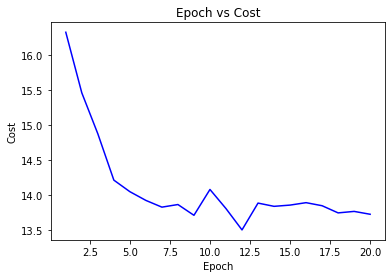

In [94]:
xlim = range(1,len(val2)+1)
plt.plot(xlim,val2,'b')
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Epoch vs Cost")
plt.show()

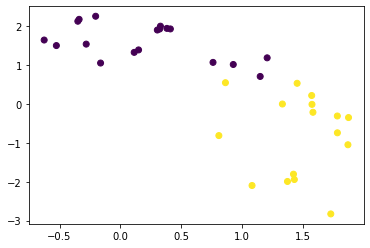

In [95]:
x = model.Phi[:,0] # first dimension of embedding matrix
y = model.Phi[:,1] # second dimension os embedding matrix
plt.scatter(x,y,c= label[:,1])
plt.show()

### case 2) p<1<q

In [96]:
#I followed the pseudo code, with gamma = 5 as suggested
gamma = 5
model2 = SkipGram(V=34) # 초기화
val2 = []

# Epochs
for epoch in range(20):
    val = []
    #for gamms
    for k in range(gamma):
        #shuffle V(graph)
        shuffled_node = np.arange(df.shape[0]) 
        np.random.shuffle(shuffled_node)
        #Implement randomwalks-skipgram with class above
        for i in range(len(shuffled_node)):
            root = shuffled_node[i]
            seq = randomwalks( v = root, q=100, p=1/100)
            values = model2.train(G=df, walks = seq,neg_sample=5)
            val.append(values)
    # I calulcated weighted loss, divided by whole iteration including gamma multipled
    val2.append(np.sum(val)/(gamma*len(shuffled_node)))

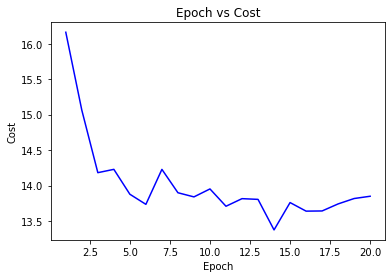

In [97]:
xlim = range(1,len(val2)+1)
plt.plot(xlim,val2,'b')
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Epoch vs Cost")
plt.show()

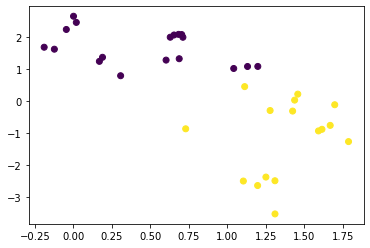

In [98]:
x = model2.Phi[:,0] # first dimension of embedding matrix
y = model2.Phi[:,1] # second dimension os embedding matrix
plt.scatter(x,y,c= label[:,1])
plt.show()

### comparison

Text(0.5, 1.0, 'karate club network')

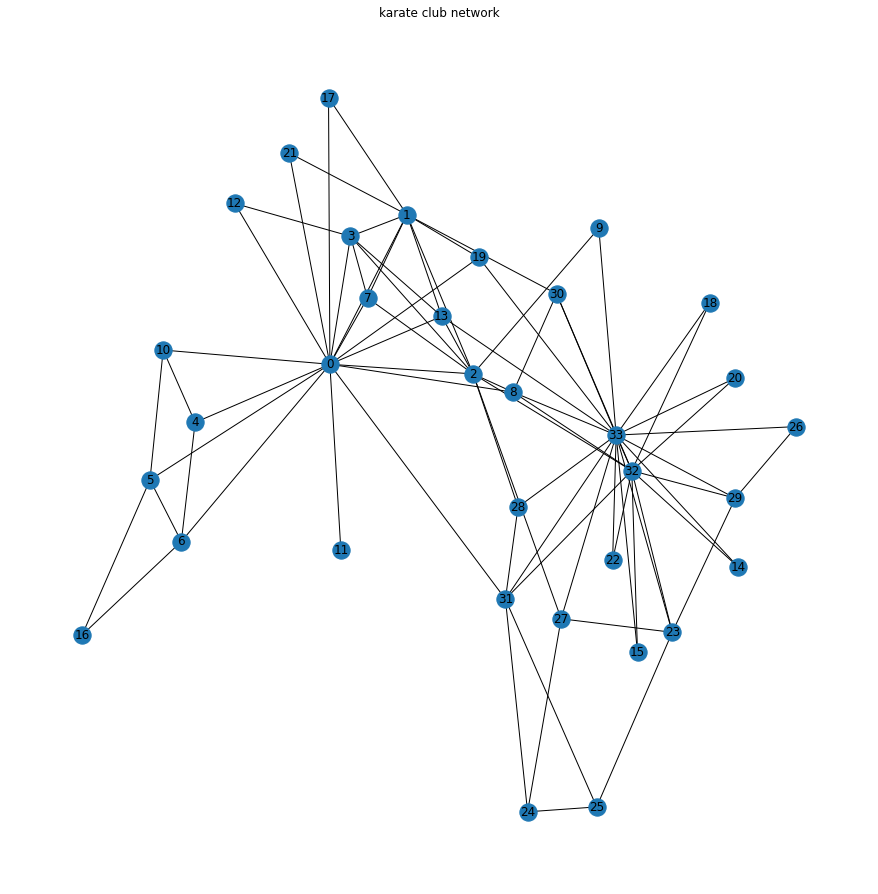

In [109]:
plt.figure(figsize = (12,12))
network = nx.read_adjlist('karate_club.adjlist')
nx.draw(network, with_labels=True) 
plt.title("karate club network")

To check how two cases are different, I checked nodes 27,28.

They have similar structural roles, but not highly interconnected.

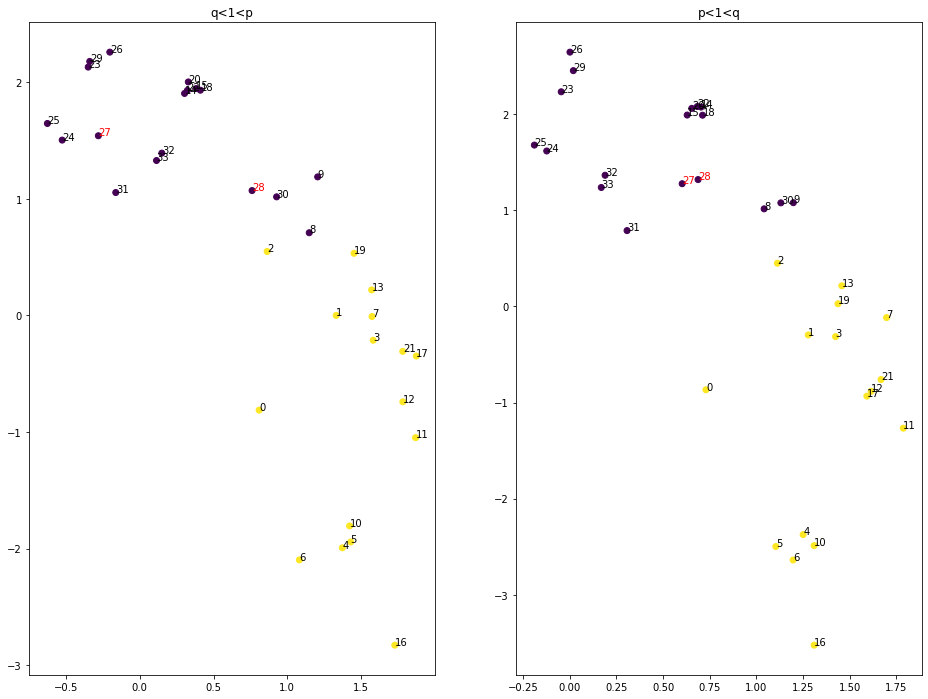

In [110]:
plt.figure(figsize=(16,12))

plt.subplot(1,2,1)
plt.scatter(model.Phi[:,0],y = model.Phi[:,1],c=label[:,1])
for i in range(df.shape[0]):
    
    if i in [27,28]:
        plt.text(model.Phi[:,0][i], model.Phi[:,1][i] ,i, c= 'r')


    else:
    
        plt.text(model.Phi[:,0][i], model.Phi[:,1][i] ,i)
plt.title("q<1<p")

plt.subplot(1,2,2)
plt.scatter(model2.Phi[:,0],y = model2.Phi[:,1],c=label[:,1])
for i in range(df.shape[0]):
    
    if i in [27,28]:
        plt.text(model2.Phi[:,0][i], model2.Phi[:,1][i] ,i, c= 'r')


    else:
    
        plt.text(model2.Phi[:,0][i], model2.Phi[:,1][i] ,i)
plt.title("p<1<q")
plt.show()

One can see that they are separated at q<1<p, but located around at p<1<q